In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import numpy as np
import random
import copy
import time
from collections import namedtuple, deque
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
from shutil import copyfile
%matplotlib inline

from IPython.display import clear_output,display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#gym-like environment
class Environment():
    
    def __init__(self,path, seed = 0):
        self.env = UnityEnvironment(file_name=path, seed=seed);
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        # self.state_size = self.brain.vector_observation_space_size # bug, returns 8 :.(
        self.action_size = self.brain.vector_action_space_size
        info = self.env.reset(train_mode=True)[self.brain_name]
        self.state_size = len(info.vector_observations[0])
        self.num_agents = len(info.agents)
        self.print_info(info.vector_observations)
        
    def close(self):
        self.env.close()
    
    def reset(self,train=True):
        info = self.env.reset(train_mode=train)[self.brain_name]
        return info.vector_observations
    
    def step(self,action):
        info = self.env.step(action)[self.brain_name]       # send all actions to tne environment
        state = info.vector_observations                    # get next state (for each agent)
        reward = info.rewards                               # get reward (for each agent)
        done = info.local_done   
        return state, reward, done, info
    
    def print_info(self, state=None):
        print('Num agents: \t', self.num_agents)
        print('State size: \t', self.state_size)
        print('Action size:\t', self.action_size)
        if state is not None:
            print('Raw State shape:\t', state.shape)
            print('Raw State content:\n', state)

In [4]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = F.relu(self.fcs1(state))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:
class ReplayBufferPrioritized:
    def __init__(self, buffer_size, batch_size, seed, min_delta=1e-5):
        self.seed = random.seed(seed)
        
        self.batch_size = batch_size
        self.min_delta = min_delta
        
        self.buffer = deque(maxlen=buffer_size)
        self.deltas = deque(maxlen=buffer_size)
        
        self.exp_template = namedtuple("exp", field_names=["state","action","reward","new_state","done"])
    
    def add(self, state, action, reward, new_state, done):
        exp = self.exp_template(state, action, reward, new_state, int(done))
        self.buffer.append(exp)
        self.deltas.append( max(self.deltas) if len(self.deltas) > 0 else self.min_delta )
    
    def sample(self,priority=0.5):
        deltas = np.array(self.deltas)
        probs = deltas**priority / np.sum(deltas**priority)
        
        exp_batch_idx = np.random.choice(np.arange(len(self.buffer)), size=self.batch_size, p=probs, replace=False)
         
        states = torch.from_numpy(np.vstack([self.buffer[idx].state for idx in exp_batch_idx])).float().to(device)
        actions = torch.from_numpy(np.vstack([self.buffer[idx].action for idx in exp_batch_idx])).float().to(device)
        rewards = torch.from_numpy(np.vstack([self.buffer[idx].reward for idx in exp_batch_idx])).float().to(device)
        new_states = torch.from_numpy(np.vstack([self.buffer[idx].new_state for idx in exp_batch_idx])).float().to(device)
        dones = torch.from_numpy(np.vstack([self.buffer[idx].done for idx in exp_batch_idx])).float().to(device)
        probabilities = torch.from_numpy(np.vstack([probs[idx] for idx in exp_batch_idx])).float().to(device)
        
        return states, actions, rewards, new_states, dones, probabilities, exp_batch_idx
    
    def update_deltas(self,idxs,deltas):
        for i,idx in enumerate(idxs):
            self.deltas[idx] = deltas[i] + self.min_delta
    
    def __len__(self):
        return len(self.buffer)

In [7]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #rnd = np.random.randn(*x.shape) 
        #rnd = np.random.random(self.size)*2-1 
        rnd = np.random.standard_normal(self.size)

        dx = self.theta * (self.mu - x) + self.sigma * rnd
        self.state = x + dx
        return self.state

In [8]:
class Agent():
    """Interacts with and learns from the environment."""
    memory = None
    share_memory = False
    
    def __init__(self, num_agents, state_size, action_size, buffer_size, batch_size, learn_every, update_every, random_seed, use_pre):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.use_pre = use_pre
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size
        self.learn_every = learn_every
        self.update_every = update_every
        self.seed = random.seed(random_seed)
        self.buffer_size = buffer_size
        self.batch_size = batch_size

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size*2, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size*2, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        
        memory_class = ReplayBuffer
        if self.use_pre:
            memory_class = ReplayBufferPrioritized
        
        # Replay memory
        if Agent.share_memory:
            if Agent.memory is None:        
                Agent.memory = memory_class(self.buffer_size, self.batch_size, random_seed)
            self.memory = Agent.memory
        else:
            self.memory = memory_class(self.buffer_size, self.batch_size, random_seed)
    
    def step(self, state, action, reward, next_state, done, priority=0.0):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        #for i in range(self.num_agents):
        self.memory.add(state, action, reward, next_state, done)
        
        self.i_step += 1            
        should_learn = (self.i_step % self.learn_every ) == 0
        should_update = ( self.i_step % self.update_every ) == 0
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            if should_learn:
                #print('learn',self.i_step)
                experiences = None
                if self.use_pre:
                    experiences = self.memory.sample(priority)
                else:
                    experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
        
            if should_update:
                #print('update',self.i_step)
                self.soft_update(self.critic_local, self.critic_target, TAU)
                self.soft_update(self.actor_local, self.actor_target, TAU) 

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
        self.i_step=0

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        if self.use_pre:
            states, actions, rewards, next_states, dones, probs, batch_idx = experiences
        else:
            states, actions, rewards, next_states, dones = experiences
        
        #print(states.shape)
        #print(actions.shape)
        state_actor, state_critic = states[:,:self.state_size], states[:,self.state_size:]
        next_state_actor, next_state_critic = next_states[:,:self.state_size], next_states[:,self.state_size:]
            
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_state_actor)
        Q_targets_next = self.critic_target(next_state_critic, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(state_critic, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(state_actor)
        actor_loss = -self.critic_local(state_critic, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()    
        
        if self.use_pre:
            Q_error = Q_expected - Q_targets
            new_deltas = torch.abs(Q_error.detach().squeeze(1)).numpy()
            self.memory.update_deltas(batch_idx,new_deltas)
            

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [9]:
BATCH_SIZE = 128        # minibatch size
BUFFER_SIZE = int(1e5)  # replay buffer size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0.001        # L2 weight decay
UPDATE_EVERY = 1        # Update global network ever n-steps
LEARN_EVERY  = 1        # Train local network ever n-steps
RANDOM_SEED = 0
NUM_EPISODES = 4000
USE_PRE = True
USE_NOISE = True
AGENT_SHARE_MEMORY = True
PRE_PRIORITY_START = 1.0
PRE_PRIORITY_END = 0.3
PRE_PRIORITY_DECAY = 0.9999

session_name = str(int(time.time()))

env = Environment('Tennis.app', seed = RANDOM_SEED)

agent_config = {
    'num_agents':env.num_agents,
    'state_size':env.state_size,
    'action_size':env.action_size,
    'buffer_size':BUFFER_SIZE,
    'batch_size':BATCH_SIZE,
    'learn_every':LEARN_EVERY,
    'update_every':UPDATE_EVERY,
    'random_seed':RANDOM_SEED,
    'use_pre':USE_PRE
    
}

print('session_name',session_name)
Agent.share_memory=AGENT_SHARE_MEMORY
agent1 = Agent(**agent_config)
agent2 = Agent(**agent_config)

session_name 1541097899


In [10]:
def ddpg(n_episodes=NUM_EPISODES):
    pri = PRE_PRIORITY_START
    print_every=100
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = 0
    for i_episode in range(1, n_episodes+1):
        states = env.reset()
        agent1.reset()
        agent2.reset()
        score = np.zeros(env.num_agents)
        pri = max(pri*PRE_PRIORITY_DECAY, PRE_PRIORITY_END)
        while True:
            actions1 = agent1.act(states[0], add_noise=USE_NOISE)
            actions2 = agent2.act(states[1], add_noise=USE_NOISE) 
            
            next_states, rewards, dones, _ = env.step([actions1,actions2])
            
            states_critic = np.reshape(states,(-1))
            states1 = np.concatenate( (states[0],states_critic) )
            states2 = np.concatenate( (states[1],states_critic) )
            
            next_states_critic = np.reshape(next_states,(-1))
            next_states1 = np.concatenate( (next_states[0],next_states_critic) )
            next_states2 = np.concatenate( (next_states[1],next_states_critic) )
            
            
            
            agent1.step(states1, actions1, rewards[0], next_states1, dones[0], pri)
            agent2.step(states2, actions2, rewards[1], next_states2, dones[1], pri)
            
            score += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        scores_deque.append(score)
        scores.append(score)
        avg_score_ep = np.mean(score)
        avg_score_100 = np.mean(scores_deque)
        print('\rEpisode {}\t Score: {:.2f} \tAverage Score: {:.2f}'.format(i_episode,avg_score_ep, avg_score_100 ), end="")
        
        if i_episode % print_every == 0:
            print('') # skip line
        
        if avg_score_100>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, avg_score_100))
            if avg_score_100 > max_score:
                max_score = avg_score_100
                filename_tpl = 'checkpoints/checkpoint-{}-{}-EP_{}-score_{:.3f}.pth'
                filename_tpl_best = 'checkpoints/checkpoint-{}-{}-best.pth'
                
                filename_actor1 = filename_tpl.format(session_name,'actor1', i_episode, avg_score_100)
                filename_critic1 = filename_tpl.format(session_name,'critic1', i_episode, avg_score_100)
                
                filename_actor2 = filename_tpl.format(session_name,'actor2', i_episode, avg_score_100)
                filename_critic2 = filename_tpl.format(session_name,'critic2', i_episode, avg_score_100)
                
                torch.save(agent1.actor_local.state_dict(), filename_actor1)
                torch.save(agent1.critic_local.state_dict(), filename_critic1)
                
                torch.save(agent2.actor_local.state_dict(), filename_actor2)
                torch.save(agent2.critic_local.state_dict(), filename_critic2)
                
                copyfile(filename_actor1, filename_tpl_best.format(session_name,'actor1') )
                copyfile(filename_critic1, filename_tpl_best.format(session_name,'critic1') )
                copyfile(filename_actor2, filename_tpl_best.format(session_name,'actor2') )
                copyfile(filename_critic2, filename_tpl_best.format(session_name,'critic2') )
                
                
    return scores

scores = ddpg()


Episode 100	 Score: -0.00 	Average Score: -0.00
Episode 200	 Score: -0.00 	Average Score: -0.00
Episode 300	 Score: -0.00 	Average Score: -0.00
Episode 400	 Score: -0.00 	Average Score: -0.00
Episode 500	 Score: -0.00 	Average Score: 0.010
Episode 600	 Score: -0.00 	Average Score: 0.01
Episode 700	 Score: -0.00 	Average Score: 0.01
Episode 800	 Score: -0.00 	Average Score: 0.000
Episode 900	 Score: -0.00 	Average Score: 0.000
Episode 1000	 Score: -0.00 	Average Score: -0.00
Episode 1100	 Score: -0.00 	Average Score: -0.00
Episode 1200	 Score: 0.05 	Average Score: 0.0000
Episode 1300	 Score: 0.05 	Average Score: 0.022
Episode 1400	 Score: 0.05 	Average Score: 0.033
Episode 1500	 Score: -0.00 	Average Score: 0.05
Episode 1600	 Score: 0.05 	Average Score: 0.066
Episode 1700	 Score: 0.10 	Average Score: 0.066
Episode 1800	 Score: 0.15 	Average Score: 0.066
Episode 1900	 Score: 0.05 	Average Score: 0.077
Episode 2000	 Score: 0.10 	Average Score: 0.088
Episode 2100	 Score: 0.25 	Average Scor

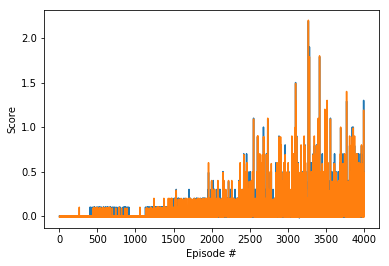

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
#session_name = ''
filename_tpl_best = 'checkpoints/checkpoint-{}-{}-best.pth'

checkpoint_actor1 = filename_tpl_best.format(session_name,'actor1')
checkpoint_actor2 = filename_tpl_best.format(session_name,'actor2')

agent1.actor_local.load_state_dict(torch.load(checkpoint_actor1))
agent2.actor_local.load_state_dict(torch.load(checkpoint_actor2))
        
state = env.reset(train=False)     
agent1.reset()
agent2.reset()
scores = np.zeros(env.num_agents)                          
while True:
    action1 = agent1.act(state[0], add_noise=False)
    action2 = agent2.act(state[1], add_noise=False)
    next_state, reward, done, _ = env.step([action1,action2])
    scores += reward                         
    state = next_state                              
    if np.any(done):                              
        break
print('Total score:',np.mean(scores))

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/checkpoint-1541097899-actor1-best.pth'